In [1]:
#%%writefile ../crypto_chaotic/lorenz_attractor.py
import numpy as np
from math import sin, cos, sqrt

class Lorenz_Attractor:
    def __init__(self,N = 3, tstep = 0.0001, ndrop = 15000, 
                 rho = 25, sigma = 10, beta = 1.5, 
                 blocksize = 102400, pregen=True):
        self.rho = rho
        self.sigma = sigma
        self.beta = beta
        self.N = N
        self.tstep = tstep
        self.ndrop = ndrop
        self.pregen = pregen
        self.blocksize = blocksize
        if self.pregen:
            self.xt = self.pre_generate(self.blocksize)
        self.xrgen_called = 0

    def deriv_send(self, xdot, x):
        xdot[0]=self.sigma * (x[1] - x[0])
        xdot[1]=x[0] * self.rho - x[1] - x[0] * x[2]
        xdot[2]=x[0] * x[1] - self.beta * x[2]
        return 0

    def deriv_receive(self, xdot, x, xp):
        xdot[0]=self.sigma * (x[1] - x[0])
        xdot[1]=xp * self.rho - x[1] - xp * x[2]
        xdot[2]=xp * x[1] - self.beta * x[2]
        return 0

    def rkm_send(self, h, x, N):
        xdot0 = np.zeros(N, dtype=np.float64)
        xdot1 = np.zeros(N, dtype=np.float64)
        xdot2 = np.zeros(N, dtype=np.float64)
        xdot3 = np.zeros(N, dtype=np.float64)
        g = np.zeros(N, dtype=np.float64)

        hh = h * 0.5
        self.deriv_send(xdot0, x)
        for i in range(N):
            g[i] = x[i] + hh * xdot0[i]

        self.deriv_send(xdot1, g)
        for i in range(N):
            g[i] = x[i] + hh * xdot1[i]

        self.deriv_send(xdot2, g)
        for i in range(N):
            g[i] = x[i] + h * xdot2[i]

        self.deriv_send(xdot3, g)
        for i in range(N):
            x[i] = x[i] + h * (xdot0[i] + 2.0 * 
                               (xdot1[i] + xdot2[i]) + 
                               xdot3[i]) / 6.0
        return 0

    def rkm_receive(self, h, x, xp, N):
        xdot0 = np.zeros(N, dtype=np.float64)
        xdot1 = np.zeros(N, dtype=np.float64)
        xdot2 = np.zeros(N, dtype=np.float64)
        xdot3 = np.zeros(N, dtype=np.float64)
        g = np.zeros(N, dtype=np.float64)

        hh = h * 0.5
        self.deriv_receive(xdot0, x, xp)
        for i in range(N):
            g[i] = x[i] + hh * xdot0[i]

        self.deriv_receive(xdot1, g, xp)
        for i in range(N):
            g[i] = x[i] + hh * xdot1[i]

        self.deriv_receive(xdot2, g, xp)
        for i in range(N):
            g[i] = x[i] + h * xdot2[i]

        self.deriv_receive(xdot3, g, xp)
        for i in range(N):
            x[i] = x[i] + h * (xdot0[i] + 2.0 * 
                               (xdot1[i] + xdot2[i]) + 
                               xdot3[i]) / 6.0

        return 0


    def pre_generate(self, nosdata):
        xt = np.zeros(nosdata, dtype=np.float64)

        xold = np.random.uniform(0, 1, size=self.N)    
        for i in range(self.ndrop):
            self.rkm_send(self.tstep, xold, self.N)

        for i in range(nosdata):
            self.rkm_send(self.tstep, xold, self.N)
            xt[i] = xold[0]
        return xt

    def chaos_encrypt(self, signal):
        nosdata = len(signal)
        encryptedx = np.zeros(nosdata, dtype=np.float64)

        if not self.pregen:
            xt = self.pre_generate(nosdata)
        else:
            xt = np.tile(self.xt, nosdata/self.blocksize)
            print len(xt), len(self.xt), nosdata, self.blocksize
            
        for i in range(nosdata):
            encryptedx[i] =  signal[i] + xt[i]

        return encryptedx, xt
    
    def chaos_encrypt_block(self, signal):
        nosdata = len(signal)
        encryptedx = np.zeros(nosdata, dtype=np.float64)
        xt = np.zeros(self.blocksize, dtype=np.float64)

        if not self.pregen:
            print 'chaos real time generation'
            xt = self.pre_generate(self.blocksize)
        else:
            #print 'chaos offline generation'
            xt = self.xt
            
        xt = np.tile(xt, nosdata/self.blocksize)
        
        encryptedx =  signal + xt

        return encryptedx, xt

    def pre_generate_xr(self, encryptedx):        
        xr = np.zeros(len(encryptedx), dtype=np.float64)
        
        xold = np.random.uniform(0, 1, size=self.N)
        for i in range(self.ndrop):
            self.rkm_send(self.tstep, xold, self.N)
        
        for i in range(len(encryptedx)):
            self.rkm_receive(self.tstep, xold, encryptedx[i], self.N)
            xr[i] = xold[0]
        return xr

    def chaos_decrypt(self, encryptedx):
        nosdata = len(encryptedx)
        if not self.pregen:
            xr = self.pre_generate_xr(encryptedx)
        else:
            xr = np.tile(self.xr, nosdata/self.blocksize)
            
        for i in range(nosdata):
            recovered = encryptedx - xr

        return recovered, xr

                
    def chaos_decrypt_block(self, encryptedx):
        nosdata = len(encryptedx)

        if not self.pregen:
            print 'chaos real time syncronisation'
            xr = self.pre_generate_xr(encryptedx)
        elif self.xrgen_called == 0:
            print 'chaos offline syncronisation'
            self.xrgen_called = 1
            self.xr = self.pre_generate_xr(encryptedx[:self.blocksize])
            xr = np.tile(self.xr, nosdata/self.blocksize)
        else:
            xr = np.tile(self.xr, nosdata/self.blocksize)

        recovered = encryptedx - xr

        return recovered, xr

In [2]:
#%%writefile ../crypto_chaotic/modulation.py
import numpy as np
from math import sin, cos, sqrt, pi
import matplotlib.pyplot as plt
import scipy 

def drawfft(signals, xlow=0, xhigh=0, ylow=0, yhigh=0):
    plt.figure(figsize=(15, 5))    
    if xlow < xhigh:
        plt.xlim([xlow,xhigh])
    if ylow < yhigh:
        plt.ylim([ylow,yhigh])
        
    for i in signals:
        sp = np.abs(np.fft.fft(i))
        freq = np.fft.fftfreq(len(sp), 1)

        Nindex = np.argmax(freq < 0)
        freq1 = freq[:Nindex]
        sp1 = sp[:Nindex]
        plt.plot(freq1, sp1)
    plt.show()
    
def plotamp(signals, xmin = 0, xmax = 0):    
    plt.figure(figsize=(15, 5))    
    x = range(len(signals[0]))
    if xmin < xmax:
        xi, xl = (xmin, xmax);
    else:
        xi, xl = (0, -1);
    print xi, xl
    for i in signals:
        plt.plot(x[xi: xl],i[xi: xl])
    plt.show()
    
class Modulation:
    def __init__(self, p = 100, sampling = 1, E=1, filter_del = 0.0029):
        self.times = sampling
        self.p = p
        self.filter_del = filter_del
        self.Scarrier  = np.array([E * sin((2*pi/self.p) * i)     for i in range(self.p*self.times)], dtype=np.float)
        self.NScarrier = np.array([E * sin((2*pi/self.p) * i+ pi) for i in range(self.p*self.times)], dtype=np.float)
        self.Ccarrier  = np.array([E * cos((2*pi/self.p) * i)     for i in range(self.p*self.times)], dtype=np.float)
        self.NCcarrier = np.array([E * cos((2*pi/self.p) * i+ pi) for i in range(self.p*self.times)], dtype=np.float)
    
    def filter_signal(self, signal):        
        #########################################
        ###         Frequency Domain          ###
        #########################################
        W = scipy.fftpack.fftfreq(signal.size, d=1)
        f_signal = scipy.fftpack.rfft(signal)

        #########################################
        ###              Filter               ###
        #########################################
        cut_f_signal = f_signal.copy()
        #print (W<0.5/p)
        cut_f_signal[(W>(2.0/p)+self.filter_del)] = 0
        cut_f_signal[(W<(2.0/p)-self.filter_del)] = 0

        #########################################
        ###            Time Domain            ###
        #########################################
        modsig_cut_signal = scipy.fftpack.irfft(cut_f_signal)
        return modsig_cut_signal

        
    def qpsk_modulate(self, signal):
        nosdata = len(signal)
        modsig = np.array([], dtype=np.float)
        for i in range(nosdata):
            modsig = np.append(modsig, self.NScarrier)
            sig = int(signal[i])
            for k in range(32):
                if sig&0x01:
                    S = self.NScarrier
                else:
                    S = self.Scarrier

                if sig&0x02:
                    C = self.NCcarrier
                else:
                    C = self.Ccarrier
                modsig = np.append(modsig, S + C)
                sig = sig >> 2
        print '###'
        print len(self.NScarrier)*33*10
        print len(modsig)
        return self.filter_signal(modsig)



    def qpsk_demodulate(self, signal):
        modsig = self.filter_signal(signal)
        nosdata = len(modsig)/(self.p*self.times*33)
        val = []
        rval = 0
        for i in range(nosdata):
            
            for k in range(32):
                #print k
                x = self.Scarrier * modsig[(i*33+k+1)*self.p*self.times:(i*33+k+2)*self.p*self.times]
                y = self.Ccarrier * modsig[(i*33+k+1)*self.p*self.times:(i*33+k+2)*self.p*self.times]
                if x.mean() < 0:
                    cval = 1
                else:
                    cval = 0
                if y.mean() < 0:
                    sval = 1
                else:
                    sval = 0
                dval = cval ^ sval <<1
                rval = rval ^ dval <<(k*2)
            val.append(rval)
            rval = 0

        return np.array(val, dtype=np.uint64)


In [14]:
#%pylab inline
from matplotlib import rcParams
import matplotlib.pyplot as plt
import numpy as np
from random import randrange
from scipy.fftpack import rfft, irfft, fftfreq

nosdata = 10 * 1 #00
p = 80
E = 1.0
sampling = 12 #5
filter_del = 0.0029
blocksize = p*sampling*33

tstep = 0.01
ndrop = 150 #15000
N = 3
rho=25
sigma=10
beta=1.5

modulation = Modulation(p = p, sampling = sampling, E = E, filter_del=filter_del)
lorenz_attractor = Lorenz_Attractor(N = N, tstep = tstep, ndrop = ndrop, 
                                    rho = rho, sigma = sigma, beta = beta, 
                                    blocksize = blocksize, pregen=True)
#########################################
###     Random Signal Generation      ###
#########################################
signal = np.array([randrange(0, 2**64) for i in range(nosdata)], dtype=np.uint64)
#print signal
#signalbypass = np.zeros(nosdata*32*p*sampling, dtype=np.uint64)

sigarray =  np.split(signal, len(signal)/10)

print len(signal)
print len(sigarray)
def transmitter(sigarray):
    encsig = np.array([], dtype=np.uint64)
    encryptedx = np.array([], dtype=np.uint64)
    modsig = np.array([], dtype=np.uint64)
    xt = np.array([], dtype=np.uint64)
    for i in sigarray:
        #########################################
        ###          QPSK Modulation          ###
        #########################################
        modsig = modulation.qpsk_modulate(i)
        #########################################
        ###           Chaos Encrypt           ###
        #########################################
        encryptedx, xt = lorenz_attractor.chaos_encrypt_block(modsig)
        encsig = np.append(encsig, encryptedx)
    return modsig, encryptedx, xt, encsig

%time modsig, encryptedx, xt, encsig = transmitter(sigarray)
print len(encsig), len(modsig), blocksize

10
1
###
316800
316800
CPU times: user 123 ms, sys: 10 ms, total: 133 ms
Wall time: 134 ms
316800 316800 31680


Populating the interactive namespace from numpy and matplotlib
0 2000


`%matplotlib` prevents importing * from pylab and numpy


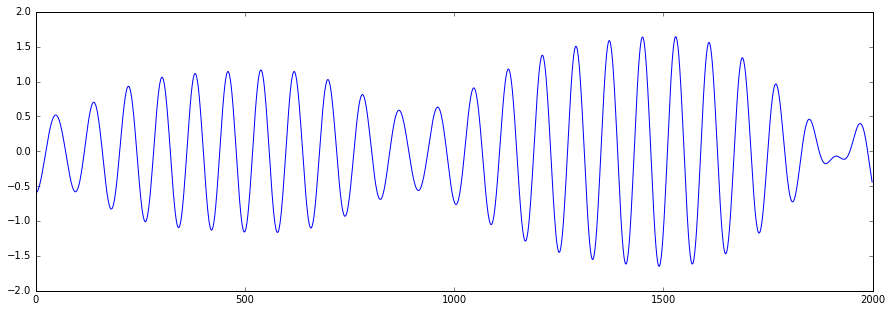

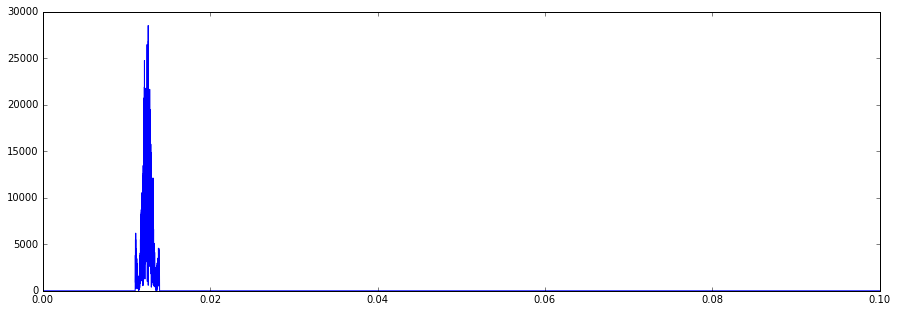

In [15]:
%pylab inline
plotamp([modsig], xmin = 0, xmax = 2000)

drawfft([modsig], xlow=0, xhigh=0.1, ylow=0, yhigh=0)

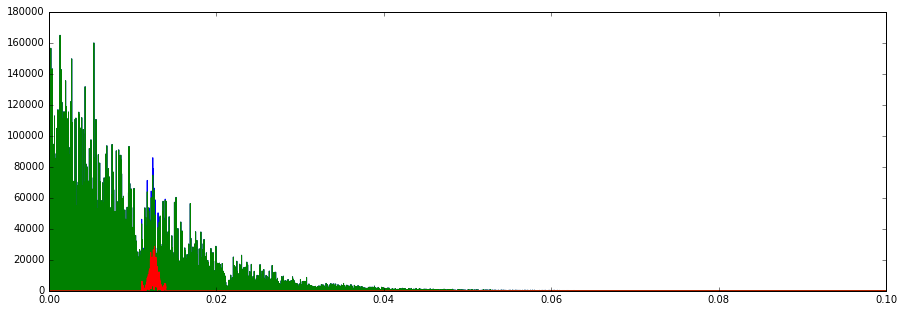

In [16]:
drawfft([encryptedx, xt, modsig], xlow=0, xhigh=0.1, ylow=0, yhigh=0)

In [18]:
encsigarray =  np.split(encsig, len(encsig)/(blocksize*10))

print len(encsig)
print blocksize*10
print len(encsigarray)
def reciever(encsigarray):
    dmodsig = np.array([], dtype=np.uint64)
    for i in encsigarray:
        #########################################
        ###           Chaos Decrypt           ###
        #########################################
        recovered, xr = lorenz_attractor.chaos_decrypt_block(i)

        #########################################
        ###        QPSK Demodulation          ###
        #########################################
        #print len(recovered)
        dmodsig1 = modulation.qpsk_demodulate(recovered)
        dmodsig = np.append(dmodsig, dmodsig1)
    return recovered, xr, dmodsig1, dmodsig
%time recovered, xr, dmodsig1, dmodsig = reciever(encsigarray)

316800
316800
1
CPU times: user 40 ms, sys: 6.67 ms, total: 46.7 ms
Wall time: 46.7 ms


0 -1


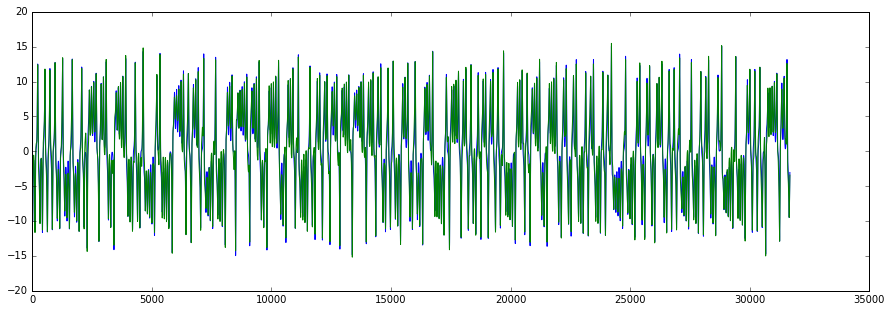

0 -1


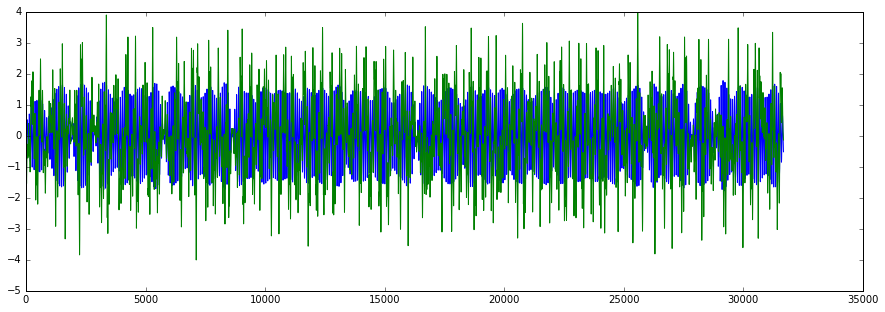

In [19]:
n = 0
plotamp([xt[n*blocksize:(n+1)*blocksize], xr[n*blocksize:(n+1)*blocksize]], xmin = 0, xmax = 0)
plotamp([modsig[n*blocksize:(n+1)*blocksize], recovered[n*blocksize:(n+1)*blocksize]], xmin = 0, xmax = 0)

In [20]:
#########################################
###        Comparing Signals          ###
#########################################
if (signal == dmodsig).all():
    print 'matched'
else:
    print 'error'
k = 0
for i,j in zip(signal, dmodsig):
    if i != j:
        print k, hex(i ^ j), i^j
    k += 1
    

#print signal, dmodsig

matched


0 2000


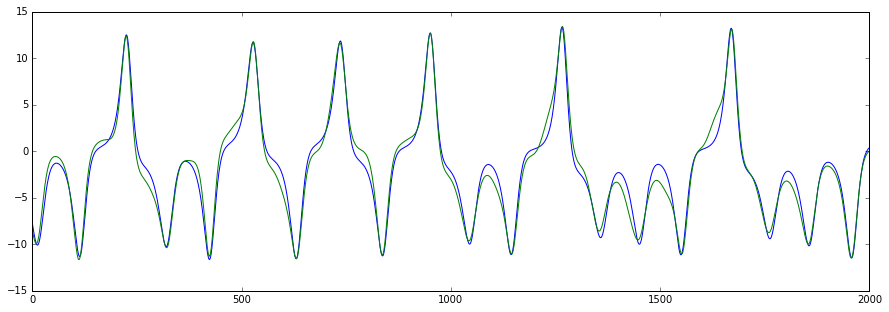

0 2000


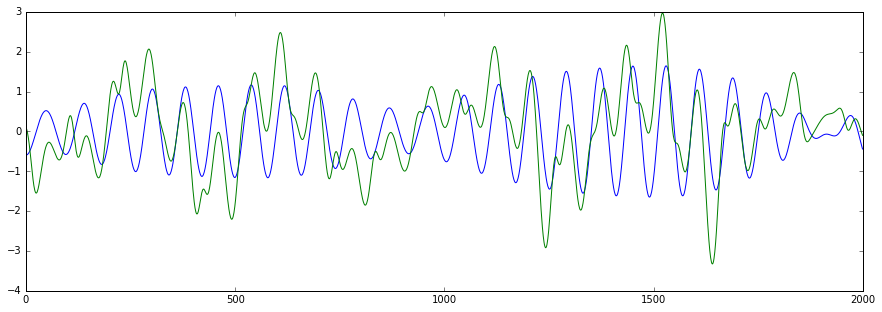

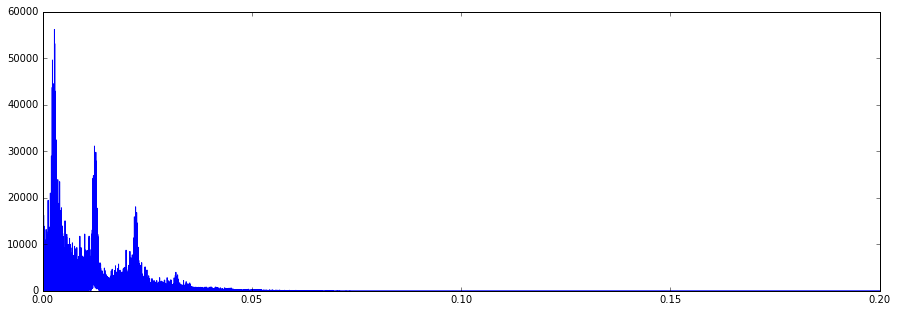

In [21]:
#########################################
###          Plot Signals             ###
#########################################
plotamp([xt, xr], xmin = 0, xmax = 2000)
plotamp([modsig, 
         recovered, 
        ], xmin = 0, xmax = 2000)
drawfft([recovered], xlow=0, xhigh=0.2, ylow=0, yhigh=0)

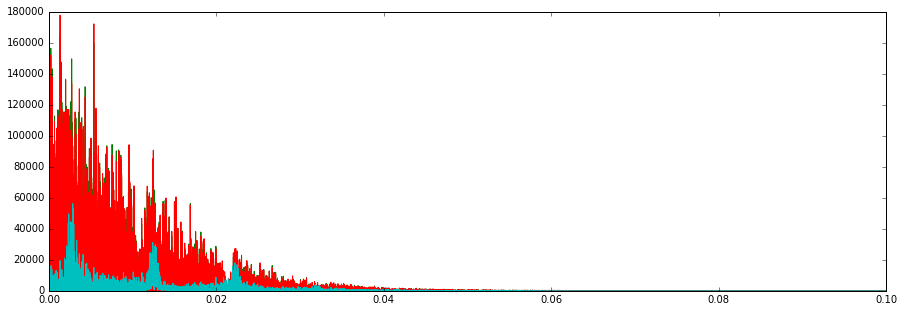

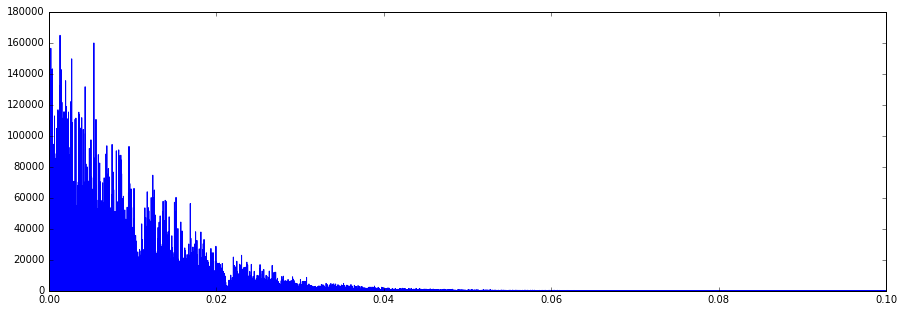

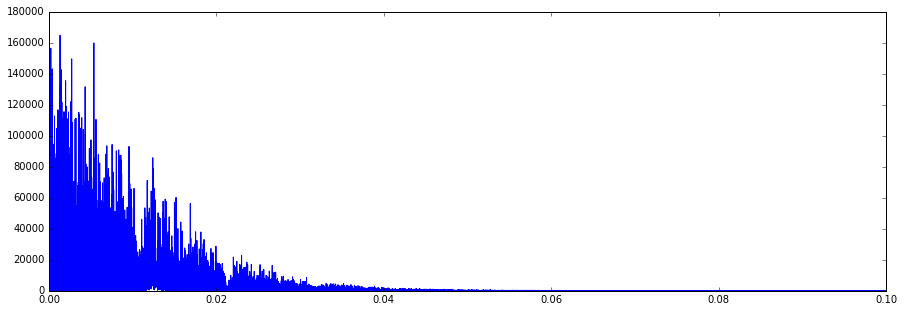

In [22]:
drawfft([modsig, xt, 
                    xr, recovered, 
                   ], xlow=0, xhigh=0.1, ylow=0, yhigh=0)

drawfft([xt,
                   ], xlow=0, xhigh=0.1, ylow=0, yhigh=0)

drawfft([encryptedx
                   ], xlow=0, xhigh=0.1, ylow=0, yhigh=0)